In [90]:
import numpy as np
import networkx as nx
import kmapper as km
import sklearn
import warnings
import matplotlib.pyplot as plt
import signal
import time
import random


warnings.filterwarnings("ignore")

# Graph Similarity & TDA
**Author**: Bao Ngo

**Last updated** : 30 May

**Abstract**: Compare the similariry scores of 2 graphs before applying TDA transformation and after applying TDA method

**Description**: 
- `Similarity score` is calculated by implementing algorithm that can by find in this paper: https://www.cs.cmu.edu/~jingx/docs/DBreport.pdf

- Similarity test is conducted by compare the simmilarity score between 2 graphs before and after apply TDA method in the sample of graphs generating using `Erdos Renyl(ER) Model`





# Similarity score methods

**Find the smallest k such that the sum of the k largest eigenvalues constitutes at least 90% of the sum of all of the eigenvalues**

In [3]:
def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0 
    
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

**Method to calculate similarity score between 2 graphs**

In [4]:
def calculate_similarity(graph1,graph2):
    laplacian1 = nx.spectrum.laplacian_spectrum(graph1)
    laplacian2 = nx.spectrum.laplacian_spectrum(graph2)
    
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2) #k are different between the two graphs, then use the smaller one.
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2) #sum of the squared differences between the largest k eigenvalues
    return similarity


# TDA methods

**Create data for TDA method by extracting 5 node features:**
 - `Pagerank`
 - `Degree centrality`
 - `Closeness centrality`
 - `Betweenes centrality `
 - `Clustering`


In [5]:
def extract_graph_features(graph):
    pr = nx.pagerank(graph,0.9)
    dc = nx.degree_centrality(graph)
    cc = nx.closeness_centrality(graph)
    bx = nx.betweenness_centrality(graph)
    c = nx.clustering(graph)
    
    #create list for each features
    pr_list =  [i for i in pr.values()]
    dc_list =  [i for i in dc.values()]
    cc_list =  [i for i in cc.values()]
    bx_list =  [i for i in bx.values()]
    c_list =  [i for i in c.values()]
    d_list = [val for (node, val) in graph.degree()]
    data = np.column_stack((pr_list,dc_list,cc_list,bx_list,c_list,d_list))
    return data

**TDA tramsformation method, which take in graph represent data,extracting from each graph, and return a new graph**

In [136]:
def TDA_transformation(data):
    Xfilt = data
    mapper = km.KeplerMapper()
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    Xfilt = scaler.fit_transform(Xfilt)
    lens = mapper.fit_transform(Xfilt, projection=sklearn.manifold.TSNE())
    cls = 2  # We use cls= 5

    graph = mapper.map(lens,Xfilt,clusterer=sklearn.cluster.KMeans(n_clusters=cls,random_state=1618033),
        cover=km.Cover(n_cubes=5, perc_overlap=0.7))
    return km.to_nx(graph)

# Similarity test on TDA methods
**Method to conduct test similarity test on 2 graph**

*This method will return `true` if graphs after TDA transformation are more similar*

In [7]:
def is_TDA_capture_better(learning_graph, neighbour_graph):
    isBetter = False
    original_similarity_score = calculate_similarity(learning_graph,neighbour_graph)
    TDA_learning_graph = TDA_transformation(extract_graph_features(learning_graph))
    TDA_neighbour_graph = TDA_transformation(extract_graph_features(neighbour_graph))
    TDA_similarity_score = calculate_similarity(TDA_learning_graph,TDA_neighbour_graph)
    if(TDA_similarity_score < original_similarity_score ): isBetter = True
    return isBetter

**Method to conduct similarity test for each graph and their neighbour in the sample of graphs generating by using `ER model`**

*This method will return the fraction between the case that similarity score of two graphs after applying TDA transformation is `higher` and the total of similarity tests*

In [8]:
def compare_similarity_TDA_graph(n_low_bound,n_upper_bound,n_step, p_low_bound,p_upper_bound,p_step ):
    case_TDA_better = 0
    total_cases = 0
    n_range_length = round((n_upper_bound - n_low_bound)/n_step) + 1
    p_range_length = round((p_upper_bound - p_low_bound)/p_step) + 1
    
    for i in range(p_range_length):
        for j in range(n_range_length):
            n = n_low_bound + n_step*j
            p = p_low_bound + p_step*i
            target_graph = nx.erdos_renyi_graph(n,p)
            #Compare current graph with neighbour graphs
            if(i-1 >=0):
                p_neighbour = p_low_bound + p_step*(i-1)
                neighbour_graph = nx.erdos_renyi_graph(n,p_neighbour)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
            if(i + 1 < p_range_length):
                p_neighbour = p_low_bound + p_step*(i+1)
                neighbour_graph = nx.erdos_renyi_graph(n,p_neighbour)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
            if(j - 1 >= 0):
                n_neighbour = n_low_bound + n_step*(j-1)
                neighbour_graph = nx.erdos_renyi_graph(n_neighbour,p)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
            if(j + 1 < n_range_length):
                n_neighbour = n_low_bound + n_step*(j+1)
                neighbour_graph = nx.erdos_renyi_graph(n_neighbour,p)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
                
    return case_TDA_better/total_cases

# Final result

*The fraction below is generating by conducting the sample of graphs generated by `ER model` with* 
 - ***[ 20,50 ]** and **1** are the range of n and increment step, respectively*
  - ***[ 0.1,0.9 ]** and **0.1** are the range of n and increment step, respectively*

In [109]:
score = compare_similarity_TDA_graph(n_low_bound = 20,n_upper_bound= 50,n_step = 1,p_low_bound = 0.1,p_upper_bound= 0.9,p_step = 0.1)
score

0.9584942084942085

# Result with similary score threshold

*Graphs are generated with threshold is 20 for the similarity score between 2 graphs in order to have 2 learnning graphs with similarity score below 20, if it takes longer than 5 seconds to generate, skip that iteration.*

In [10]:
def graph_generator(target_graph,n,p):
    start_time = time.time()
    duraiton = 5
    while time.time() - start_time < duraiton:
        G = nx.erdos_renyi_graph(n,p)
        score = calculate_similarity(target_graph,G)
        if score < 10:
            return G
        time.sleep(0.1)
    return None #return None if take longer than 5s to generate expected graphs

In [9]:
def compare_similarity_TDA_graph_threshold(n_low_bound,n_upper_bound,n_step, p_low_bound,p_upper_bound,p_step ):
    case_TDA_better = 0
    total_cases = 0
    n_range_length = round((n_upper_bound - n_low_bound)/n_step) + 1
    p_range_length = round((p_upper_bound - p_low_bound)/p_step) + 1
    
    for i in range(p_range_length):
        for j in range(n_range_length):
            n = n_low_bound + n_step*j
            p = p_low_bound + p_step*i
            target_graph = nx.erdos_renyi_graph(n,p)
            #Compare current graph with neighbour graphs
            if(i-1 >=0):
                p_neighbour = p_low_bound + p_step*(i-1)
                neighbour_graph = graph_generator(target_graph,n,p_neighbour)
                if(neighbour_graph != None):
                    if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                    total_cases += 1
            if(i + 1 < p_range_length):
                p_neighbour = p_low_bound + p_step*(i+1)
                neighbour_graph = graph_generator(target_graph,n,p_neighbour)
                if(neighbour_graph != None):
                    if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                    total_cases += 1
            if(j - 1 >= 0):
                n_neighbour = n_low_bound + n_step*(j-1)
                neighbour_graph = graph_generator(target_graph,n_neighbour,p)
                if(neighbour_graph != None):
                    if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                    total_cases += 1
            if(j + 1 < n_range_length):
                n_neighbour = n_low_bound + n_step*(j+1)
                neighbour_graph = graph_generator(target_graph,n_neighbour,p)
                if(neighbour_graph != None):
                    if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                    total_cases += 1
                
    return case_TDA_better/total_cases

In [110]:
score = compare_similarity_TDA_graph_threshold(n_low_bound = 20,n_upper_bound= 50,n_step = 1,p_low_bound = 0.1,p_upper_bound= 0.3,p_step = 0.1)
score


0.8225806451612904

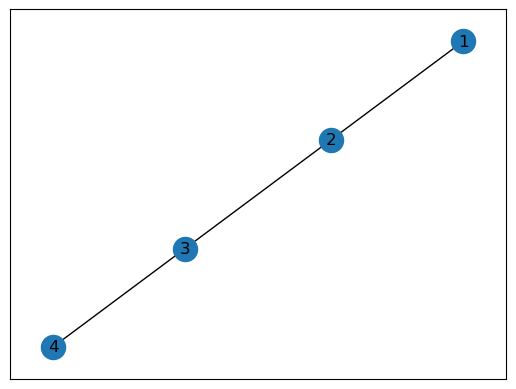

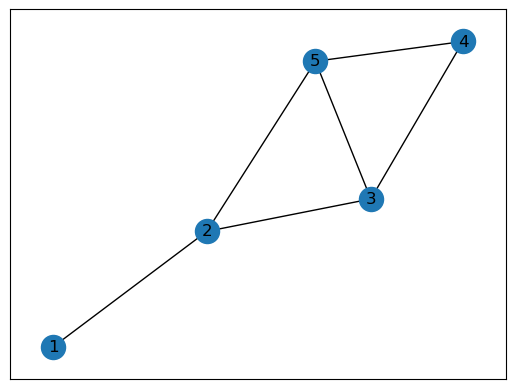

In [91]:
graph = nx.Graph()
graph.add_edges_from([(1, 2), (2, 3), (3, 4)])
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True)
plt.show()

# Add a new node to the graph
new_node = 5
graph.add_node(new_node)

# Randomly add edges between the new node and existing nodes
existing_nodes = list(graph.nodes())[:-1]  # Exclude the new node
for existing_node in existing_nodes:
    if random.random() < 0.5:  # Adjust the probability as needed
        graph.add_edge(new_node, existing_node)
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True)
plt.show()

In [96]:
def add_node_to_graph(graph,new_node,p):
    new_graph = graph.copy()
    new_graph.add_node(new_node)
    existing_nodes = list(graph.nodes())[:-1]  # Exclude the new node
    for existing_node in existing_nodes:
        if random.random() < p:  
            new_graph.add_edge(new_node, existing_node)
    return new_graph
    

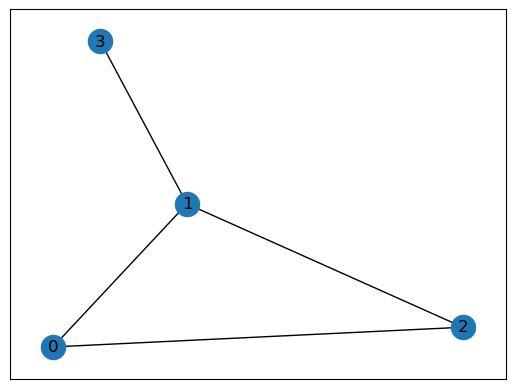

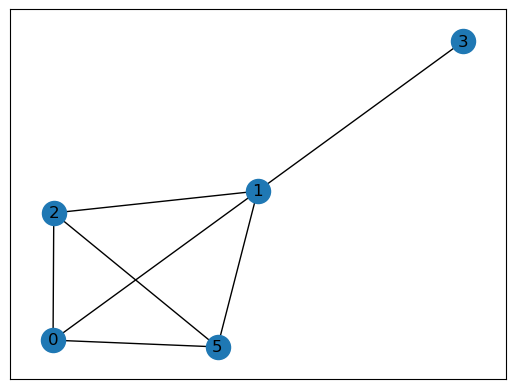

In [98]:
graph = nx.erdos_renyi_graph(4,0.5)
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True)
plt.show()
new_graph = add_node_to_graph(graph,5,0.9)
pos = nx.spring_layout(new_graph)
nx.draw_networkx(new_graph, with_labels=True)
plt.show()


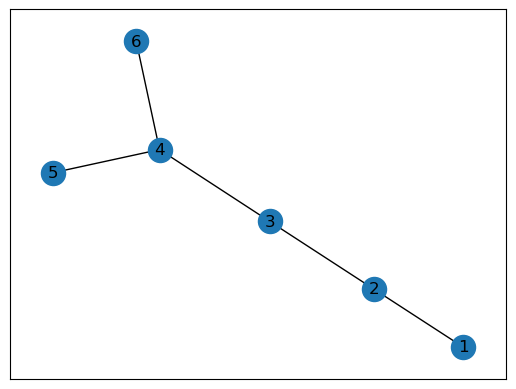

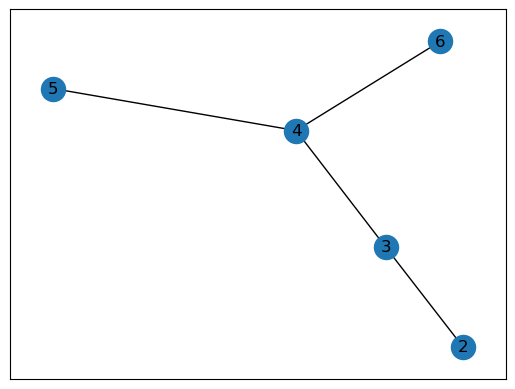

In [99]:
graph = nx.Graph()
graph.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (4, 6)])

pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True)
plt.show()

# Calculate the degree of each node
degrees = graph.degree()

# Find the node with the minimum degree
min_degree_node = min(degrees, key=lambda x: x[1])[0]

# Remove the node with the minimum degree
graph.remove_node(min_degree_node)
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True)
plt.show()

In [100]:
def remove_least_degree_node(graph):
    degrees = graph.degree()
    min_degree_node = min(degrees, key=lambda x: x[1])[0]
    # Remove the node with the minimum degree
    new_graph = graph.copy()
    new_graph.remove_node(min_degree_node)
    return new_graph

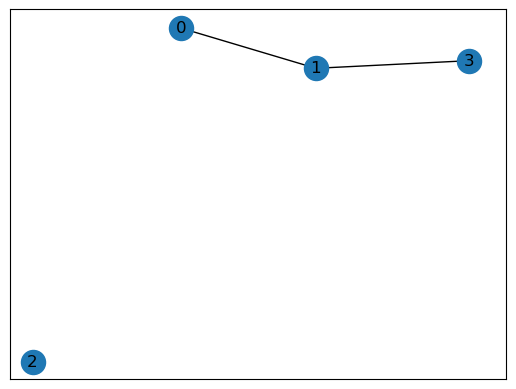

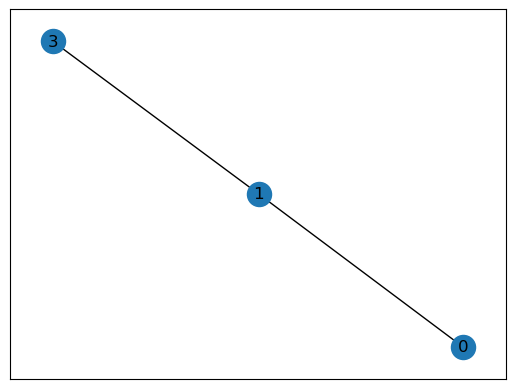

In [101]:
graph = nx.erdos_renyi_graph(4,0.5)
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True)
plt.show()
new_graph = remove_least_degree_node(graph)
pos = nx.spring_layout(new_graph)
nx.draw_networkx(new_graph, with_labels=True)
plt.show()

In [ ]:
node1 = random.randint(1,n)
node2 = random.randint(1,n)
while G.has_edge(node1,node2) or node1 == node2 :
    node1 = random.randint(1,n)
    node2 = random.randint(1,n)
curr_G.add_edge(node1,node2)

In [109]:
def random_add_new_edge(graph,p,n):
    new_graph = graph.copy()
    if random.random() < p:
        node1 = random.randint(1,n)
        node2 = random.randint(1,n)
        while G.has_edge(node1,node2) or node1 == node2 :
            node1 = random.randint(1,n)
            node2 = random.randint(1,n)
        new_graph.add_edge(node1,node2)
    return new_graph

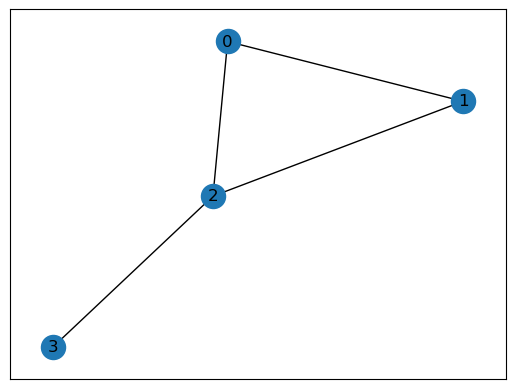

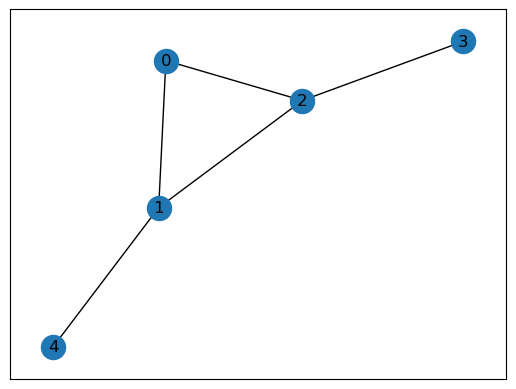

In [105]:
graph = nx.erdos_renyi_graph(4,0.5)
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True)
plt.show()
new_graph = random_add_new_edge(graph,0.9,4)
pos = nx.spring_layout(new_graph)
nx.draw_networkx(new_graph, with_labels=True)
plt.show()

In [114]:
def random_remove_edge(graph,p):
    new_graph = graph.copy()
    if random.random() < p:
        random_edge = random.choice(list(graph.edges()))

        # Remove the randomly selected edge
        new_graph.remove_edge(*random_edge)
    return new_graph

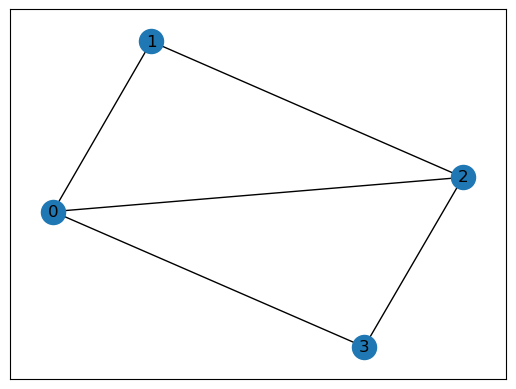

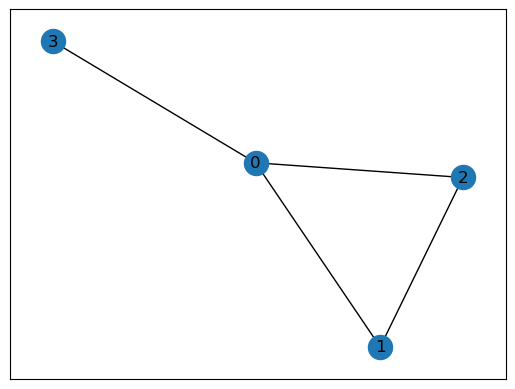

In [110]:
graph = nx.erdos_renyi_graph(4,0.5)
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True)
plt.show()
new_graph = random_remove_edge(graph,0.9,4)
pos = nx.spring_layout(new_graph)
nx.draw_networkx(new_graph, with_labels=True)
plt.show()

In [115]:
def compare_similarity_TDA_graph_v2(n_low_bound,n_upper_bound,n_step, p_low_bound,p_upper_bound,p_step ):
    case_TDA_better = 0
    total_cases = 0
    n_range_length = round((n_upper_bound - n_low_bound)/n_step) + 1
    p_range_length = round((p_upper_bound - p_low_bound)/p_step) + 1
    
    for i in range(p_range_length):
        for j in range(n_range_length):
            n = n_low_bound + n_step*j
            p = p_low_bound + p_step*i
            target_graph = nx.erdos_renyi_graph(n,p)
            #Compare current graph with neighbour graphs
            if(i-1 >=0):
                p_neighbour = p_low_bound + p_step*(i-1)
                neighbour_graph = random_remove_edge(target_graph,p_neighbour)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
            if(i + 1 < p_range_length):
                p_neighbour = p_low_bound + p_step*(i+1)
                neighbour_graph = random_add_new_edge(target_graph,p_neighbour,n)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
            if(j - 1 >= 0):
                n_neighbour = n_low_bound + n_step*(j-1)
                neighbour_graph = remove_least_degree_node(target_graph)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
            if(j + 1 < n_range_length):
                n_neighbour = n_low_bound + n_step*(j+1)
                neighbour_graph = add_node_to_graph(target_graph,n_neighbour,p)
                if(is_TDA_capture_better(target_graph,neighbour_graph)):case_TDA_better += 1
                total_cases += 1
                
    return case_TDA_better/total_cases

In [ ]:
score = compare_similarity_TDA_graph_v2(n_low_bound = 20,n_upper_bound= 23,n_step = 1,p_low_bound = 0.5,p_upper_bound= 0.9,p_step = 0.1)
score
